# Data Masters: Case

## Bibliotecas

In [176]:
# --- Data Exploration --- #
import numpy as np
import pandas as pd

# --- Classification model --- #
from sklearn.ensemble import GradientBoostingClassifier

# --- Model Evaluation --- #
from sklearn.metrics import auc, confusion_matrix, roc_auc_score

# --- Pipeline Building --- #
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer

# --- Cluster Analysis --- #
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- Preprocessing --- #
from sklearn.preprocessing import StandardScaler

# --- Custom Libs --- #
from resources.utils import ColumnDropper

# --- Viz --- #
import matplotlib.pyplot as plt
import seaborn as sns

## Pipeline de Classificação

In [2]:
with open("resources/drop_cols.txt") as f:
    drop_cols = [line.rstrip("\n") for line in f]

In [3]:
main_pipeline = Pipeline(
    steps=[
        ("ColDrop", ColumnDropper(drop_cols)),
        ("clf", GradientBoostingClassifier())
    ]
)

In [4]:
param_grid = {
    "clf__n_estimators": [80, 100, 200],
    "clf__learning_rate": [.01, .1, 1],
    "clf__max_depth": [4, 6, 8]
}

In [5]:
gscv = GridSearchCV(
    main_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=14,
    error_score="raise"
)

## Fit

In [140]:
df = pd.read_csv("data/train.csv")
X = df.set_index("ID")
y = df.set_index("ID")["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train = X_train.drop("TARGET", axis=1)
X_test = X_test.drop("TARGET", axis=1)

In [7]:
gscv = gscv.fit(X_train,y_train)

In [114]:
y_pred = gscv.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

0.8682277997866147

## Selecionando o melhor corte

In [125]:
def predict_probability(X, model):
    return model.predict_proba(X)[:,1]

def make_result_df(y,y_pred):
    df = y.reset_index()
    df["prob"] = y_pred
    df["pred"] = y_pred
    return df

def predict_class(y, c):
    y["pred"] = y["prob"].apply(lambda x: 1 if x >= c else 0)
    return y

def evaluate(df, c):
    tn, fp, fn, tp = confusion_matrix(
        df["TARGET"],
        predict_class(df, c)["pred"],
    ).ravel()
    return (tn*0+fp*(-10)+fn*0+tp*(100-10))/len(df)

In [126]:
def select_threshold(X, y):
    y_pred = predict_probability(X, gscv)
    df = make_result_df(y,y_pred)

    thresh_scores = [[i/100, 0] for i in range(101)]

    for i in range(len(thresh_scores)):
        c = thresh_scores[i][0]
        thresh_scores[i][1] = evaluate(df,c)

    thresh_scores = pd.DataFrame(thresh_scores,columns=["Threshold", "Profit"])

    best_threshold = thresh_scores.iloc[
        thresh_scores.Profit.idxmax()
    ].Threshold

    return best_threshold

In [127]:
c = select_threshold(X_train, y_train)

## Avaliação no conjunto de testes

In [131]:
y_pred = predict_probability(X_test, gscv)
pred_df = make_result_df(y_test, y_pred)
profit = evaluate(pred_df,c)
print(f"Lucro esperado: R${profit:.2f} por cliente da base")

Lucro esperado: R$1.03 por cliente da base


## Clusters

In [158]:
X_clust = X_test \
    .merge(y_test.reset_index(),how="left",on="ID") \
    .merge(pred_df[["ID","pred"]],how="left",on="ID")

In [159]:
def profit_individual(true,pred):
    profit = 0
    if pred == 1:
        profit += -10
        if true == 1:
            profit += 100
    return profit

X_clust["profit"] = np.vectorize(profit_individual)(X_clust["TARGET"], X_clust["pred"])

In [160]:
X_clust = X_clust.set_index("ID")

In [190]:
y_clust = X_clust[["TARGET", "pred", "profit"]]
X_clust = X_clust.drop(["TARGET", "pred", "profit"],axis=1)


In [191]:
sse = []
k_values = list(range(1,30))

for i in k_values:
    cluster_pipeline = Pipeline(
        steps=[
            ("col_drop", ColumnDropper(drop_cols)),
            ("standard_scaler", StandardScaler()),
            ("PCA", PCA()),
            (
                "KMeans",
                KMeans(
                    n_clusters=i,
                    init="k-means++",
                    n_init=10
                )
            )
        ]
    )
    km = cluster_pipeline.fit(X_clust)
    sse.append(km["KMeans"].inertia_)

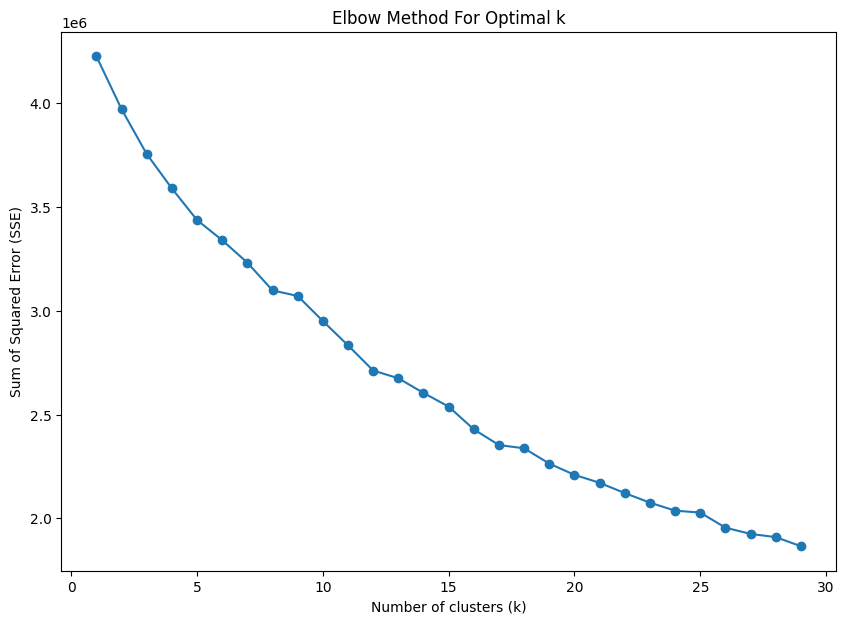

In [192]:
plt.figure(figsize=(10, 7))
plt.plot(k_values, sse, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Error (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [193]:
N_CLUSTERS = 17

In [194]:
cluster_pipeline = Pipeline(
    steps=[
        ("col_drop", ColumnDropper(drop_cols)),
        ("standard_scaler", StandardScaler()),
        ("PCA", PCA()),
        (
            "KMeans",
            KMeans(
                n_clusters=N_CLUSTERS,
                init="k-means++",
                n_init=10
            )
        )
    ]
)

In [199]:
cluster = cluster_pipeline.fit_predict(X_clust)

In [200]:
cluster_analysis = X_clust.merge(y_clust,how="left",on="ID")
cluster_analysis["cluster"] = cluster

In [204]:
cluster_analysis[["cluster","profit"]].groupby("cluster").mean().sort_values(by="profit", ascending=False)

,profit
cluster,
15,3.299265
14,3.088235
9,1.967213
12,1.696429
4,1.105651
5,0.751366
0,0.025381
10,0.000000
8,0.000000
